In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
techsash_waste_classification_data_path = kagglehub.dataset_download('techsash/waste-classification-data')

print('Data source import complete.')


Using Colab cache for faster access to the 'waste-classification-data' dataset.
Data source import complete.


<span style="color: white; background-color: green; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">♻️RESNET50 VS VGG16♻️</span>


![](http://www.clearitwaste.co.uk/wp-content/uploads/2022/01/xCIW_Waste.png.pagespeed.ic.D8betJh5Mf.png)

<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 56px; font-weight: bold;">♻️Waste classification♻️</span>


# 1- Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import tensorflow

import os
import random
from PIL import Image

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# 2 - Viewing Sample Images




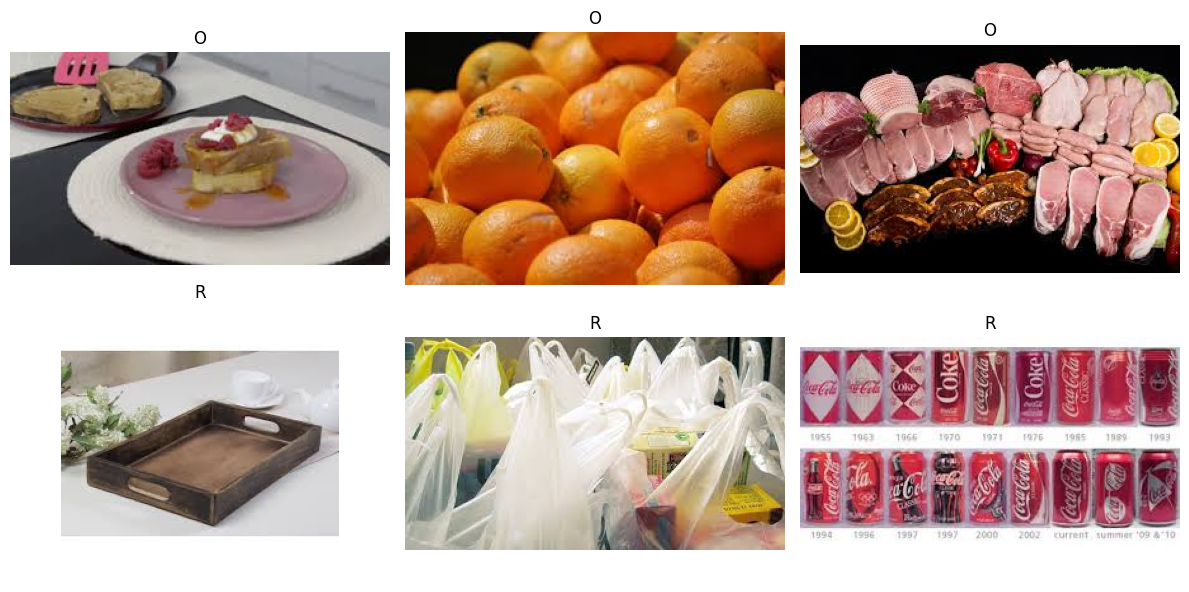

In [3]:
# Path setup
base_path = '/kaggle/input/waste-classification-data/DATASET/TRAIN'
categories = ['O', 'R']


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for row, category in enumerate(categories):
    category_path = os.path.join(base_path, category)
    image_files = os.listdir(category_path)
    selected_images = random.sample(image_files, 3)

    for col, img_file in enumerate(selected_images):
        img_path = os.path.join(category_path, img_file)
        img = Image.open(img_path)

        ax = axes[row][col]
        ax.imshow(img)
        ax.set_title(category)
        ax.axis('off')

plt.tight_layout()
plt.show()

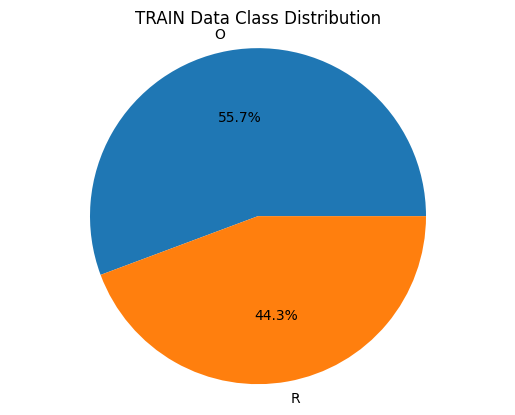

In [4]:
train_dir = '/kaggle/input/waste-classification-data/DATASET/TRAIN'

labels = ['O', 'R']
counts = [len(os.listdir(os.path.join(train_dir, label))) for label in labels]

plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title("TRAIN Data Class Distribution")
plt.axis('equal')
plt.show()


# 3 - Data Augumentation

In [5]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [6]:
train_dataset  = train_datagen.flow_from_directory(directory = '/kaggle/input/waste-classification-data/DATASET/TRAIN',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 128,
                                                   subset = 'training')



valid_dataset = valid_datagen.flow_from_directory(directory = '/kaggle/input/waste-classification-data/DATASET/TRAIN',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 128,
                                                  subset = 'validation')

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.


# 4- Model Building - VGG16

In [7]:
# Defining Model

base_model = VGG16(input_shape=(224,224,3),
                   include_top=False,
                   weights="imagenet")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [9]:
# Summary

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
# Defining Layers

model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [11]:
# Summary

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,927,873 (106.54 MB)

 Trainable params: 13,160,961 (50.21 MB)

 Non-trainable params: 14,766,912 (56.33 MB)

In [12]:
# Model Compile

adam = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=adam)

In [13]:
# Defining Callbacks

filepath = './best_model.keras'

earlystopping = EarlyStopping(monitor='val_accuracy',
                              mode='max',
                              patience=2,
                              verbose=1)

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

callback_list = [earlystopping, checkpoint]

In [14]:
# Model Fitting

model_history = model.fit(train_dataset,
                          validation_data=valid_dataset,
                          epochs=5,
                          callbacks=callback_list,
                          verbose=1)

Epoch 1/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8307 - loss: 0.4022
Epoch 1: val_accuracy improved from -inf to 0.87234, saving model to ./best_model.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 0.8309 - loss: 0.4017 - val_accuracy: 0.8723 - val_loss: 0.3017
Epoch 2/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8873 - loss: 0.2708
Epoch 2: val_accuracy improved from 0.87234 to 0.88608, saving model to ./best_model.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.8873 - loss: 0.2708 - val_accuracy: 0.8861 - val_loss: 0.2772
Epoch 3/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8990 - loss: 0.2450
Epoch 3: val_accuracy did not improve from 0.88608
142/142 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.8990 - loss: 0.2450 - val_accuracy: 0.8814 - val_loss: 0.2973
Epoch 4/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9074 - loss: 0.2262
Epoch 4: val_accuracy improved from 0.88608 to 0.88652, saving model to ./best_m

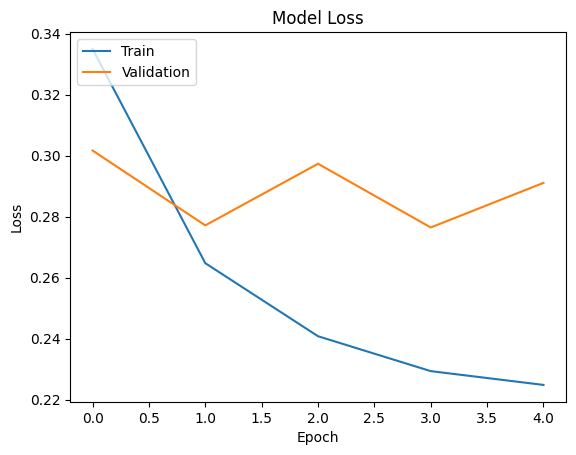

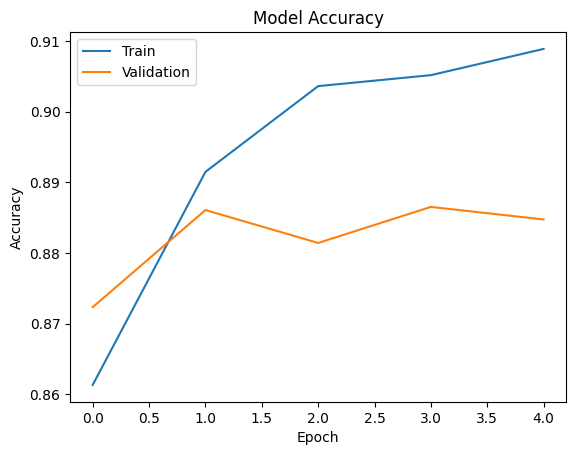

In [15]:
# Summarize the model loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Summarize model accuracy

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
# Test Data

test_data = test_datagen.flow_from_directory(directory = '/kaggle/input/waste-classification-data/DATASET/TEST',
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             batch_size = 128)

Found 2513 images belonging to 2 classes.


In [17]:

model.evaluate(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8773 - loss: 0.3697


[0.37316834926605225, 0.8746517896652222]

# 5- Model Building -RESNET50

In [18]:
resnet = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
# Freezing Layers

for layer in resnet.layers:
    layer.trainable=False

In [20]:
# Defining Layers

model2=Sequential()
model2.add(resnet)
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(BatchNormalization())
model2.add(Dense(512,kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(512,kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1,activation='sigmoid'))

In [21]:
# Summary

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100352)         │       401,408 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,637,121 (288.53 MB)

 Trainable params: 51,846,657 (197.78 MB)

 Non-trainable params: 23,790,464 (90.75 MB)

In [22]:
adam = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model2.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=adam)

In [23]:
# Defining Callbacks

earlystopping = EarlyStopping(monitor='val_accuracy',
                              mode='max',
                              patience=2,
                              verbose=1)


callback_list = [earlystopping]

In [24]:
# Model Fitting

history = model2.fit(train_dataset,
                          validation_data=valid_dataset,
                          epochs=5,
                          callbacks=callback_list,
                          verbose=1)

Epoch 1/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.7063 - loss: 0.5910 - val_accuracy: 0.7343 - val_loss: 0.5380
Epoch 2/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.7637 - loss: 0.5017 - val_accuracy: 0.7498 - val_loss: 0.5157
Epoch 3/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.7790 - loss: 0.4827 - val_accuracy: 0.7540 - val_loss: 0.5024
Epoch 4/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.7792 - loss: 0.4692 - val_accuracy: 0.7702 - val_loss: 0.4915
Epoch 5/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.7871 - loss: 0.4632 - val_accuracy: 0.7773 - val_loss: 0.4740


In [25]:
model2.evaluate(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 815ms/step - accuracy: 0.7807 - loss: 0.4972


[0.49870651960372925, 0.7811380624771118]

# 6- Image Prediction Demo

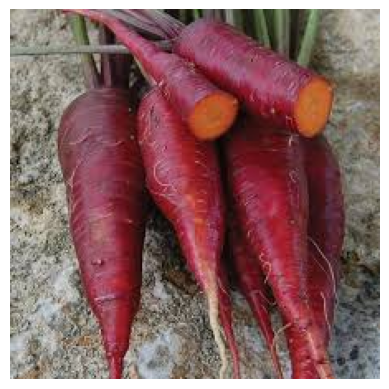

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
The image belongs to **Organic waste** category


In [35]:
# Load and preprocess the image
img = load_img('/kaggle/input/waste-classification-data/DATASET/TEST/O/O_12571.jpg', target_size=(224, 224))
img_array = img_to_array(img) / 255.0  # Normalize to [0,1]
plt.imshow(img_array)
plt.axis('off')
plt.show()


# Expand dimensions to match model input shape: (1, 224, 224, 3)
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)

# Interpret the prediction
if prediction[0][0] > 0.5:
    print("The image belongs to **Recycle waste** category")
else:
    print("The image belongs to **Organic waste** category")

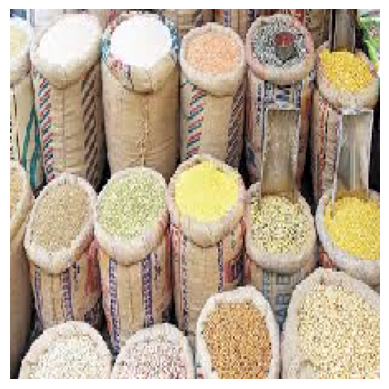

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
The image belongs to **Organic waste** category


In [73]:
# Load and preprocess the image
img = load_img('/kaggle/input/waste-classification-data/DATASET/TEST/O/O_13486.jpg', target_size=(224, 224))
img_array = img_to_array(img) / 255.0  # Normalize to [0,1]
plt.imshow(img_array)
plt.axis('off')
plt.show()


# Expand dimensions to match model input shape: (1, 224, 224, 3)
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)

# Interpret the prediction
if prediction[0][0] > 0.5:
    print("The image belongs to **Recycle waste** category")
else:
    print("The image belongs to **Organic waste** category")

# 7- Saving the Model

In [27]:
model.save('model.h5')

<span style="color: black; background-color: yellow; padding: 10px 20px; border-radius: 10px; font-size: 56px; font-weight: bold;">       ♻️Keep Learning and Keep Upvoting♻️     </span>
